<a href="https://colab.research.google.com/github/edhillon7/Neural-Networks/blob/main/exp3_ffn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train Accuracy: 0.8166666666666667
Test Accuracy: 0.7666666666666667


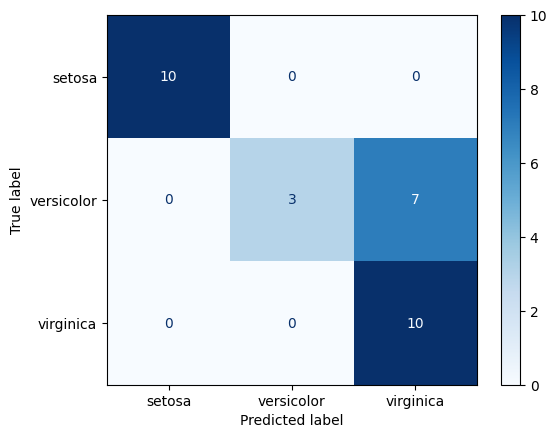

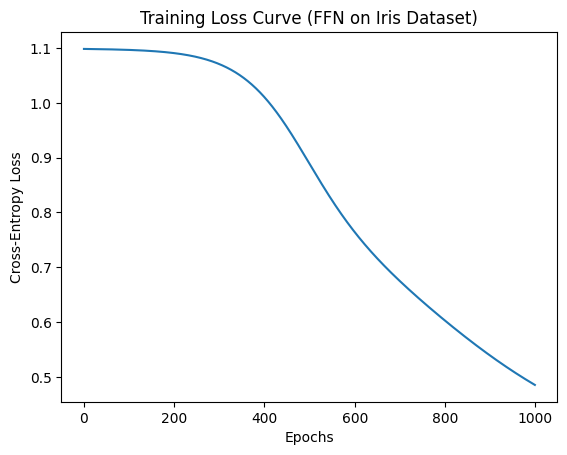

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# ----------------------------
# Load and preprocess dataset
# ----------------------------
iris = load_iris()
X = iris.data  # features
y = iris.target.reshape(-1, 1)  # labels

# One-hot encode target
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y
)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# ----------------------------
# Helper functions
# ----------------------------
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # stability trick
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def cross_entropy_loss(y_true, y_pred):
    eps = 1e-9
    return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1))


# ----------------------------
# Build Feedforward Neural Net
# ----------------------------
class FeedForwardNN:
    def __init__(self, input_dim, hidden_dim, output_dim, lr=0.01):
        # Initialize weights
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.01
        self.b2 = np.zeros((1, output_dim))
        self.lr = lr

    def forward(self, X):
        self.Z1 = X.dot(self.W1) + self.b1
        self.A1 = relu(self.Z1)
        self.Z2 = self.A1.dot(self.W2) + self.b2
        self.A2 = softmax(self.Z2)  # probabilities
        return self.A2

    def backward(self, X, y_true, y_pred):
        m = X.shape[0]

        # Output layer gradients
        dZ2 = y_pred - y_true
        dW2 = self.A1.T.dot(dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Hidden layer gradients
        dA1 = dZ2.dot(self.W2.T)
        dZ1 = dA1 * relu_derivative(self.Z1)
        dW1 = X.T.dot(dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # Update weights
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def train(self, X, y, epochs=1000):
        loss_history = []
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = cross_entropy_loss(y, y_pred)
            loss_history.append(loss)
            self.backward(X, y, y_pred)
        return loss_history

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)


# ----------------------------
# Train the model
# ----------------------------
model = FeedForwardNN(input_dim=4, hidden_dim=10, output_dim=3, lr=0.01)
loss_history = model.train(X_train, y_train, epochs=1000)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Convert y_test from one-hot to class indices
y_test_labels = np.argmax(y_test, axis=1)

# Accuracy
print("Train Accuracy:", accuracy_score(np.argmax(y_train, axis=1), y_pred_train))
print("Test Accuracy:", accuracy_score(y_test_labels, y_pred_test))

# ----------------------------
# Confusion Matrix
# ----------------------------
cm = confusion_matrix(y_test_labels, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap="Blues")
plt.show()

# ----------------------------
# Loss Curve
# ----------------------------
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss Curve (FFN on Iris Dataset)")
plt.show()
